#### Database structure:

Publications(pmid, year, title, abstract, ta_search) - 28M records, ta_search is a `tsvector` for full text search in both title and abstract

Citations(pmid_citing, pmid_cited) - approx. 60M records

CitationsCount(pmid, count) - can be created in 30+ minutes

In [4]:
import networkx as nx
import pandas as pd
import psycopg2 as pg_driver

from Bio import Entrez
Entrez.email = 'oleg.shpynov@gmail.com'

In [5]:
def search(*terms):
    query=' '.join(terms)
    handle = Entrez.esearch(db='pubmed',  
                            retmax='100000',
                            retmode='xml', 
                            term=query)
    results = Entrez.read(handle)
    return results

In [6]:
class PubmedDatabaseHandler:  
    def __init__(self):
        self.fields = ['pmid', 'year', 'title', 'abstract']
        self.conn = pg_driver.connect(dbname='pubmed', user='biolabs', password='pubtrends', host='localhost')
        self.cursor = self.conn.cursor()
        
    def size(self):
        self.cursor.execute('SELECT COUNT(1) FROM Publications;')
        result = []
        
        for row in self.cursor:
            result.append(row)
            
        return result[0]
    
    def create_citation_count_table(self):
        query = f'SELECT pmid_cited AS pmid, COUNT(1) INTO CitationsCount FROM Citations GROUP BY pmid_cited'
        with self.conn:
            self.cursor.execute(query)
        
    def get_paper_by_id(self, pmid):
        query = f'SELECT {",".join(self.fields)} FROM Publications WHERE pmid={pmid}'
        result = []
        
        self.cursor.execute(query)
        for row in self.cursor:
            result.append(row)
            
        # No duplicate PMIDs should exist, otherwise there is a problem with data storage
        assert len(result) == 1
        
        return result[0]
    
    def get_top_cited_papers(self, year_min=None, year_max=None, limit=10):
        # TODO: use year range
        query = f'SELECT pmid, count FROM CitationsCount ORDER BY count DESC LIMIT {limit}';
        result = []
        
        self.cursor.execute(query)
        for row in self.cursor:
            result.append(row)
            
        assert len(result) == limit
        
        return result
    
    def get_papers_by_keywords(self, *keywords):
        return self.get_papers_by_keywords_pubmed(*keywords)
    
    # TODO: decrease execution time 
    def get_papers_by_keywords_local(self, *keywords):
        # Drop previous subset
        with self.conn:
            self.cursor.execute('DROP TABLE IF EXISTS PublicationsSubset;')
            
        # Make subset for new keywords
        tsquery = ' & '.join(keywords)
        query = f"SELECT * INTO PublicationsSubset FROM Publications WHERE ta_search @@ to_tsquery('{tsquery}');"
        print(query)
        with self.conn:
            self.cursor.execute(query)
            
    def get_papers_by_keywords_pubmed(self, *keywords):
        results = search(*keywords)
        pmids = [int(pmid) for pmid in results['IdList']]
        
        with self.conn:
            self.cursor.execute('SELECT pmid, year, title FROM Publications WHERE pmid = ANY(%s)', (pmids,))
            
        data = []
        for row in db_handler.cursor:
            data.append(list(row))
            
        return data
    
    def get_citation_timeline(self, pmid):
        query = 'SELECT P.pmid, P.year FROM Citations C JOIN Publications P ON P.pmid = C.pmid_citing WHERE C.pmid_cited=%s'

        with self.conn:
            self.cursor.execute(query, (pmid,))

        data = []
        for row in db_handler.cursor:
            data.append(list(row))

        return data
  
#     def build_citation_graph(self, size):
#         dg = nx.DiGraph()
# #         self.cursor.execute('SELECT pmid_citing, pmid_cited FROM Citations;')
        
#         edges = []
# #         for row in self.cursor:
# #             assert len(row) == 2
# #             assert isinstance(row[0], int)
# #             assert isinstance(row[1], int)
# #             edges.append(row)
        
#         for i in range(size):
#             edges.append((i+1, i+2))
#         return len(edges)
    
    def close():
        self.conn.close()

In [7]:
db_handler = PubmedDatabaseHandler()

#### Number of publications

In [8]:
%time print(db_handler.size())

(29458493,)
CPU times: user 2.82 ms, sys: 5.03 ms, total: 7.85 ms
Wall time: 57.5 s


#### Get paper by PMID

In [9]:
%time print(db_handler.get_paper_by_id(20545324))

(20545324, 2010, 'The N-terminal integrity is critical for the stability and biological functions of endostatin.', 'Endostatin is an endogenous angiogenesis inhibitor, and amino acid residues H1, H3, H11, and D76 at its N-terminus coordinate with one zinc ion. Recombinant endostatin suffering from N-terminal truncations during Pichia pastoris expression was widely used in previous studies and generated inconsistent antitumor results. However, little attention was paid to the possible alteration on the stability and activity of endostatin caused by N-terminal truncations. In this study, N-terminally truncated forms of endostatin expressed by P. pastoris are identified as N-1, N-3, and N-4, in which one or two of the four zinc-binding residues are lost. The N-terminal truncation of the first amino acid residue (H) does not result in a significant change in the conformation, zinc-binding capacity, thermodynamic stability, or biological activity, while truncations of the first three amino 

#### Top cited papers

In [10]:
papers = db_handler.get_top_cited_papers()
print('PMID, Number of citations')
for paper in papers:
    print(paper[0], paper[1], sep=', ')

PMID, Number of citations
5432063, 51571
14907713, 50549
942051, 39527
11846609, 32904
18156677, 26684
271968, 21994
2231712, 21685
9254694, 20600
7984417, 14819
1202204, 14408


#### TODO: Full text search in title and abstract

In [11]:
db_handler.get_papers_by_keywords('dna', 'methylation', 'clock')

[[1722018, 1991, 'DNA methylation and cellular ageing.'],
 [1943146, 1991, 'Quantitative genetic variation and developmental clocks.'],
 [2777259,
  1989,
  'Cytosine methylation and the fate of CpG dinucleotides in vertebrate genomes.'],
 [2857475, 1985, 'Control of haemoglobin switching by a developmental clock?'],
 [11032969, 2000, 'Crisis periods and apoptotic commitment: death imprints?'],
 [11820819,
  2002,
  'Regulation of stage-specific nuclear translocation of Dnmt1o during preimplantation mouse development.'],
 [14577056, 2003, 'Genes of aging.'],
 [15779908,
  2005,
  'Structural aspects of RecA-dependent homologous strand exchange involving human telomeric DNA.'],
 [15790588,
  2005,
  'Deregulated expression of the PER1, PER2 and PER3 genes in breast cancers.'],
 [15860628,
  2005,
  'PERIOD1-associated proteins modulate the negative limb of the mammalian circadian oscillator.'],
 [15941485,
  2005,
  'Stability of colon stem cell methylation after neo-adjuvant therapy in

**Search terms via PubMed API**

In [12]:
data = db_handler.get_papers_by_keywords('dna', 'methylation', 'clock')
df = pd.DataFrame(data, columns = ['pmid', 'year', 'title'])

Text(0, 0.5, 'Number of papers')

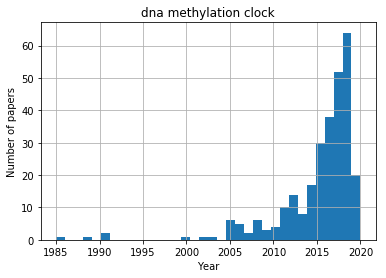

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

min_year = int(df['year'].min())
max_year = int(df['year'].max())
df['year'].hist(bins=max_year-min_year, range=(min_year, max_year+1))
plt.title('dna methylation clock')
plt.xlabel('Year')
plt.ylabel('Number of papers')

**Timeline of citations for one paper**

In [14]:
pmid = 1202204
data = db_handler.get_citation_timeline(pmid)
df = pd.DataFrame(data, columns=['pmid', 'year'])

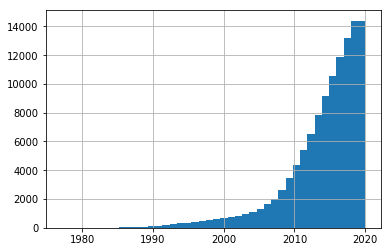

In [15]:
min_year = int(df['year'].min())
max_year = int(df['year'].max())
df['year'].hist(cumulative=True, bins=max_year-min_year, range=(min_year, max_year+1))

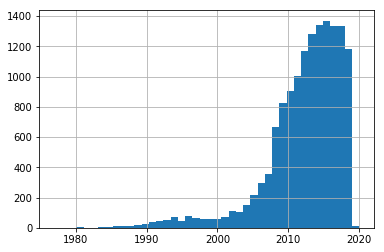

In [16]:
min_year = int(df['year'].min())
max_year = int(df['year'].max())
df['year'].hist(bins=max_year-min_year, range=(min_year, max_year+1))